# Alternative sperm exploration

Several ideas float:

- Reduce each sample (biounit) to a singular quantitiy
    - This quantity should be a measure of central tendency or dispersion
    - For central tendency -> mean, median
    - For dispersion -> standard deviation, IQR
    - Bonus : skewedness and kurtosis
- Create KDE plot for every sample with HUE as replicate to help remove outlying technical replicates



In [7]:
import pandas as pd
import seaborn as sns
from sklearn.utils import resample 
import pingouin as pg
import numpy as np
import warnings
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM

plt.style.use("ggplot")
warnings.filterwarnings("ignore") 


data = pd.read_csv("sperm_experiment.csv").iloc[:,1:]
data = data.loc[data["RED-HLin"]<8000]
samples = sorted(list(set(data.Sample)))
stat_options = ["mean","median","std","kurtosis","skew","iqrd"]

#private functions
def _mean(series):
    return (series.mean())
def _median(series):
    return(series.median())
def _std(series):
    return(series.std())
def _kurtosis(series):
    return(series.kurtosis())
def _skew(series):
    return(series.skew())
def _iqrd(series):
    return(series.quantile(.75)-series.quantile(.25))

def drawing_kdeplots(sample,**kwargs):
    """Densityplot and ECDF plot of DNA content of a particular sample"""
    fig = plt.Figure(figsize=(15,10))
    kde = fig.add_subplot(121)
    ecdf = fig.add_subplot(122)
    if "column" in kwargs:
        column = kwargs["column"]
        if column == "lin":
            col = "RED-HLin"
        else:
            col = "RED-HLog"
    else:
        col = "RED-HLin"
    sns.kdeplot(data=data.loc[data.Sample==sample],x=col,hue="Replicate",ax=kde)
    sns.ecdfplot(data=data.loc[data.Sample==sample],x=col,hue="Replicate",ax=ecdf)
    
    kde.set_xlim((0,1500))
    ecdf.set_xlim((0,1500))
    
    display(fig)
    
def statistic_calculator(statistic="mean",column="lin"):
    """
    statistic - "mean","median","std","kurtosis","skew","iqrd"
    """
    _commands = {"mean":_mean, "median":_median, "std":_std,
                 "kurtosis":_kurtosis, "skew":_skew, "iqrd":_iqrd
                }
    if column == "lin":
        col = "RED-HLin"
    else:
        col = "RED-HLog"
    
    _l = []
    for sample in samples:
        _df = data.loc[data.Sample==sample].iloc[0,:7].copy()
        series = data.loc[data.Sample==sample][col]
        stat_value = _commands[statistic](series)
        _df[statistic]=stat_value
        _l.append(_df)
        
    statistic_dataframe = pd.concat(_l,axis=1).T
    statistic_dataframe.reset_index(inplace=True,drop=True)
    statistic_dataframe.drop(["Replicate"],axis=1,inplace=True)
    statistic_dataframe.rename(columns={"Name":"Experiment"},inplace=True)
    return(statistic_dataframe)

def visualizer_statistic(statistic):
    """Swarmplot and Pointplot of {statistic}"""
    data_t = statistic_calculator(statistic)
    fig = plt.Figure(figsize=(15,5))
    singular = fig.add_subplot(121)
    pooled = fig.add_subplot(122)
    singular.set_title(f"Pointplot for Samples and their {statistic.capitalize()}")
    pooled.set_title(f"Pointplot for Treatments and their {statistic.capitalize()}")
    sns.swarmplot(data=data_t,x="Sample",y=statistic,hue="Treatment",ax=singular,
                 s=10) #<-every sample unique, this is good
    sns.pointplot(data=data_t,x="Experiment",hue="Treatment",y=statistic,
                  dodge=True,join=False,capsize=.1,ax=pooled) #<-samples pooled, this is also good
    display(fig)

def testing_statistic(statistic, between, parametric):
    """Statistical testing of chosen statistic"""
    data_t = statistic_calculator(statistic)
    iterator = list(set(data[between]))
    first = list(data_t.loc[data_t[between]==iterator[0]][statistic])
    second = list(data_t.loc[data_t[between]==iterator[1]][statistic])
    if parametric==True:
        test = pg.ttest(x=first,y=second,paired=False)
    else:
        test=pg.mwu(x=first,y=second)
    test.insert(0,"Between",between)
    test.insert(0,"Based on",statistic)
    display(test)

statisticW = widgets.Dropdown(options=stat_options,value=stat_options[0],description="Statistic")
betweenW = widgets.Dropdown(options=["Treatment","Experiment"],value="Treatment",description="Between")
parametricW = widgets.Checkbox(value=True,description='Parametric',disabled=False,indent=False)
samplesW = widgets.Dropdown(options=samples,value=samples[0],description="Sample: ")


## Draw KDE plots of a particular sample

In [2]:
widgets.interactive(drawing_kdeplots,sample=samplesW)

interactive(children=(Dropdown(description='Sample: ', options=(55, 56, 57, 58, 60, 87, 88, 89, 90, 91, 92), v…

## Drop the replicates that don't work

In [4]:
reps_to_drop = []
#reps_to_drop = ["55:2","56:3","57:1","90:1","92:1"] #<-visualy deduced
#reps_to_drop = ["56:3","57:1","87:1"] #<- second visual deduction
data=data.loc[~data.Replicate.isin(reps_to_drop)]
print(sorted(list(set(data.Replicate))))

['55:1', '55:2', '55:3', '56:1', '56:2', '56:3', '57:1', '57:2', '57:3', '58:1', '58:2', '58:3', '60:1', '60:2', '60:3', '87:1', '87:2', '87:3', '88:1', '88:2', '88:3', '89:1', '89:2', '89:3', '90:1', '90:2', '90:3', '91:1', '91:2', '91:3', '92:1', '92:2', '92:3']


## Visualize and Test

In [5]:
widgets.interactive(visualizer_statistic,statistic=statisticW)

interactive(children=(Dropdown(description='Statistic', options=('mean', 'median', 'std', 'kurtosis', 'skew', …

In [6]:
widgets.interactive(testing_statistic,statistic=statisticW,between=betweenW,parametric=parametricW,)

interactive(children=(Dropdown(description='Statistic', options=('mean', 'median', 'std', 'kurtosis', 'skew', …

# Bonus Round

Removing outliers from a normal distribution. Steps:

1. Approximate univariate gaussian
2. Find a threshold - defined as mean + 3 standard deviations
3. Remove all events above the threshold
4. Refit the univariate gaussian
5. Find a new threshold - defined as mean + 3 standard deviations

Algorithm stops when ratio of new and old threshold differs in 0.001

Then repeat all the steps above!




In [16]:
def threshold_gainer(data, x, tolerance=0.001):
    """
    Write a big docu here, I'll forget
    Selecting only S fraction, and do a GMM
    Truncate ~3 stdevs until convergence
        this means that mean-3stdev is selected as threshold
        and everything below that threshold is removed
        and then do another GMM fitting
    Repeat until there is convergence:
        convergence is defined when ratio of old threshold and new threshold is
        within 1+- tolerance

    Returns a threshold
    Anything above that is considered to be potential sgonia

    Parameters
    ----------
    data : pandas dataframe.
    tolerance : TYPE, optional
        DESCRIPTION. The default is 0.001.
    x : column in data. The default is "YEL-HLog".

    Returns
    -------
    None.

    """
    def get_appropriate_array(data, t, x):
        """GMM doesnt play nice for pandas series"""
        data = data.loc[data[x] < t]
        pandas_series = np.array(data[x])
        numpy_array = pandas_series.reshape(-1, 1)
        return(numpy_array)
    
    def gaussian_mixture_workflow(data, t, x):
        """short function for getting univar KDE params"""
        gm = GMM(1)
        chi_array = get_appropriate_array(data, t, x)
        gm.fit(chi_array)
        mean = float(gm.means_)
        stdev = float(gm.covariances_)**0.5
        threshold = mean+ 3*stdev
        return(threshold)

    old_t = gaussian_mixture_workflow(data, 4000, x)
    while True:
        new_t = gaussian_mixture_workflow(data, old_t, x)
        ratio = new_t/old_t
        if ratio < 1 + tolerance and ratio > 1 - tolerance:
            break
        old_t = new_t
    return(new_t)

loss_dictionary = {}
_l=[]
for item in list(set(data.Replicate)):
    _s = data.loc[data.Replicate==item]
    _t = threshold_gainer(_s,"RED-HLin")
    _subs = _s.loc[_s["RED-HLin"]<_t]
    loss = (len(_s)-len(_subs))/len(_s)
    loss_dictionary[item] = loss
    _l.append(_subs)
data = pd.concat(_l,ignore_index=True)


In [27]:
def drawing_kdeplots(sample,**kwargs):
    """Densityplot and ECDF plot of DNA content of a particular sample"""
    fig = plt.Figure(figsize=(15,10))
    kde = fig.add_subplot(121)
    ecdf = fig.add_subplot(122)
    if "column" in kwargs:
        column = kwargs["column"]
        if column == "lin":
            col = "RED-HLin"
        else:
            col = "RED-HLog"
    else:
        col = "RED-HLin"
    sns.kdeplot(data=data.loc[data.Sample==sample],x=col,hue="Replicate",ax=kde)
    sns.ecdfplot(data=data.loc[data.Sample==sample],x=col,hue="Replicate",ax=ecdf)
    
    kde.set_xlim((0,800))
    ecdf.set_xlim((0,800))
    
    display(fig)
    
def statistic_calculator(statistic="mean",column="lin"):
    """
    statistic - "mean","median","std","kurtosis","skew","iqrd"
    """
    _commands = {"mean":_mean, "median":_median, "std":_std,
                 "kurtosis":_kurtosis, "skew":_skew, "iqrd":_iqrd
                }
    if column == "lin":
        col = "RED-HLin"
    else:
        col = "RED-HLog"
    
    _l = []
    for sample in samples:
        _df = data.loc[data.Sample==sample].iloc[0,:7].copy()
        series = data.loc[data.Sample==sample][col]
        stat_value = _commands[statistic](series)
        _df[statistic]=stat_value
        _l.append(_df)
        
    statistic_dataframe = pd.concat(_l,axis=1).T
    statistic_dataframe.reset_index(inplace=True,drop=True)
    statistic_dataframe.drop(["Replicate"],axis=1,inplace=True)
    statistic_dataframe.rename(columns={"Name":"Experiment"},inplace=True)
    return(statistic_dataframe)

def visualizer_statistic(statistic):
    """Swarmplot and Pointplot of {statistic}"""
    data_t = statistic_calculator(statistic)
    fig = plt.Figure(figsize=(15,5))
    singular = fig.add_subplot(121)
    pooled = fig.add_subplot(122)
    singular.set_title(f"Pointplot for Samples and their {statistic.capitalize()}")
    pooled.set_title(f"Pointplot for Treatments and their {statistic.capitalize()}")
    sns.swarmplot(data=data_t,x="Sample",y=statistic,hue="Treatment",ax=singular,
                 s=10) #<-every sample unique, this is good
    sns.pointplot(data=data_t,x="Experiment",hue="Treatment",y=statistic,
                  dodge=True,join=False,capsize=.1,ax=pooled) #<-samples pooled, this is also good
    display(fig)

def testing_statistic(statistic, between, parametric):
    """Statistical testing of chosen statistic"""
    data_t = statistic_calculator(statistic)
    iterator = list(set(data[between]))
    first = list(data_t.loc[data_t[between]==iterator[0]][statistic])
    second = list(data_t.loc[data_t[between]==iterator[1]][statistic])
    if parametric==True:
        test = pg.ttest(x=first,y=second,paired=False)
    else:
        test=pg.mwu(x=first,y=second)
    test.insert(0,"Between",between)
    test.insert(0,"Based on",statistic)
    display(test)

statisticW = widgets.Dropdown(options=stat_options,value=stat_options[0],description="Statistic")
betweenW = widgets.Dropdown(options=["Treatment","Experiment"],value="Treatment",description="Between")
parametricW = widgets.Checkbox(value=True,description='Parametric',disabled=False,indent=False)
samplesW = widgets.Dropdown(options=samples,value=samples[0],description="Sample: ")

statisticW = widgets.Dropdown(options=stat_options,value=stat_options[0],description="Statistic")
betweenW = widgets.Dropdown(options=["Treatment","Experiment"],value="Treatment",description="Between")
parametricW = widgets.Checkbox(value=True,description='Parametric',disabled=False,indent=False)
samplesW = widgets.Dropdown(options=samples,value=samples[0],description="Sample: ")

## Draw KDE plots of a particular sample

In [28]:
widgets.interactive(drawing_kdeplots,sample=samplesW)

interactive(children=(Dropdown(description='Sample: ', options=(55, 56, 57, 58, 60, 87, 88, 89, 90, 91, 92), v…

## Drop the replicates that don't work

In [21]:
reps_to_drop = []
reps_to_drop = ["55:2","92:1"] #<-visualy deduced

data=data.loc[~data.Replicate.isin(reps_to_drop)]
print(sorted(list(set(data.Replicate))))

['55:1', '55:3', '56:1', '56:2', '56:3', '57:1', '57:2', '57:3', '58:1', '58:2', '58:3', '60:1', '60:2', '60:3', '87:1', '87:2', '87:3', '88:1', '88:2', '88:3', '89:1', '89:2', '89:3', '90:1', '90:2', '90:3', '91:1', '91:2', '91:3', '92:2', '92:3']


## Visualize and Test

In [22]:
widgets.interactive(visualizer_statistic,statistic=statisticW)

interactive(children=(Dropdown(description='Statistic', options=('mean', 'median', 'std', 'kurtosis', 'skew', …

In [23]:
widgets.interactive(testing_statistic,statistic=statisticW,between=betweenW,parametric=parametricW,)

interactive(children=(Dropdown(description='Statistic', options=('mean', 'median', 'std', 'kurtosis', 'skew', …

## Additional idea

Test directly from all the raw data

<AxesSubplot:xlabel='RED-HLin', ylabel='Density'>

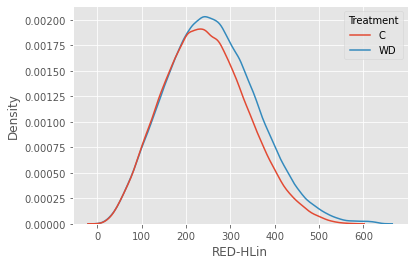

In [26]:
sns.kdeplot(data=data,x="RED-HLin",hue="Treatment")

